In [1]:
import tensorflow as tf
import numpy as np
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import argparse
import sys
import random
from itertools import product
from scipy.optimize import fsolve

random.seed(111)

In [2]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1) # cuts off tails from normal distribution, keeps elements [-2,2] #
    return tf.Variable(initial)

##### ----- Import data ---- #####
configs = np.load('toy_dataset/configs.npy')
num_configs = len(configs)
labels = np.empty([num_configs,2])
labels[:,0] = np.load('toy_dataset/labels.npy')

# convert labels into 1-hot representation
# y=0 --> (1,0)
# y=1 --> (0,1)
ind0 = (labels[:,0]==0)
ind1 = (labels[:,0]==1)
labels[ind0,:]=np.array([1,0])
labels[ind1,:]=np.array([0,1])
    
##### ----- Select training and test set ---- #####
# we choose the training set to be about 85% of the entire data set
num_train_configs = 3480
train_indices = random.sample(range(num_configs),num_train_configs)
test_indices = [ x for x in range(num_configs) if x not in train_indices]
    
configs_train = np.array( [configs[i] for i in train_indices] )
configs_test = np.array( [configs[i] for i in test_indices] )
labels_train = np.array( [labels[i] for i in train_indices] )
labels_test = np.array( [labels[i] for i in test_indices] )

In [3]:
##### ----- Create the model ---- #####
    
n_units = [12,10,7,5,4,3,2] # number of units in each layer, starting from the input layer
num_layers = len(n_units)

x = tf.placeholder(tf.float32, [None, n_units[0]])
W   = [None for i in range(num_layers-1)]
b   = [None for i in range(num_layers-1)]
out = [None for i in range(num_layers-2)]

for i in range(len(W)):
    W[i] = tf.Variable(tf.truncated_normal([n_units[i], n_units[i+1]], stddev=0.1))
    b[i] = tf.Variable(tf.truncated_normal([n_units[i+1]], stddev=0.1))

    if i==0: #first layer
        out[i] = tf.tanh( tf.matmul(x, W[i]) + b[i] )
    elif i<(len(W)-1):
        out[i] = tf.tanh( tf.matmul(out[i-1], W[i]) + b[i] )
    else: #output layer
        y = tf.matmul(out[i-1], W[i])+b[i]
    
# define loss and optimizer
y_ = tf.placeholder(tf.float32,[None,2])

cross_entropy = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_, logits=y))  # Calculate the cross entropy (this tells us whether our network is actually learning)#
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# instructions on how to train our model
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 1.6
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 10000, 0.96, staircase=True)
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)

# begin training sessions
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

# define functions for testing of the trained model
correct_prediction = tf.equal(tf.argmax(tf.sigmoid(y), 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# add ops to save and restore all the variables
saver = tf.train.Saver()

# training parameters
minibatch_size = 20     # "batching" the configuration is what introduces stochasticity into the network (this is a must!)#
num_epochs = 1000          # how many times do we run through the process and let our network learn

# define arrays to collect accuracy and error data during training
err_list  = np.zeros(num_epochs)
train_acc = np.zeros(num_epochs)
test_acc = []

# reshuffle the data set in each epoch
permut = np.arange(num_train_configs)
    
for epoch in range(num_epochs):
    # save the variables to disk
    #save_path = saver.save(sess, "/Users/annagolubeva/Desktop/Information_Bottleneck/toy_network_model_{}.ckpt".format(epoch)
    #print("Model saved in file: %s" % save_path)
    np.random.shuffle(permut)
    train_configs = configs_train[permut,:]
    train_labels = labels_train[permut,:]
    for k in range(0, num_train_configs, minibatch_size):
        batch_xs = train_configs[k:k+minibatch_size,:]
        batch_ys = train_labels[k:k+minibatch_size,:]
        sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})
        # for each epoch record one value of training accuracy and cross entropy
        if k==minibatch_size:
            train_acc[epoch] = accuracy.eval(feed_dict={x: batch_xs, y_: batch_ys})   
            err_list[epoch] = sess.run(cross_entropy, feed_dict={x: batch_xs, y_: batch_ys})
    # for every 10th epoch record the test accuracy
    if epoch%10==0:
        test_acc += [sess.run(accuracy, feed_dict={x: configs_test, y_: labels_test})]

# save arrays with accuracy and error data
np.savez_compressed('{}epochs_train_acc'.format(num_epochs), a=train_acc)
np.savez_compressed('{}epochs_test_acc'.format(num_epochs), a=test_acc)
np.savez_compressed('{}epochs_err_list'.format(num_epochs), a=err_list)

# plotting part

minibatch size = 20
number of epoches = 1000
test accuracy final epoch = 0.498377


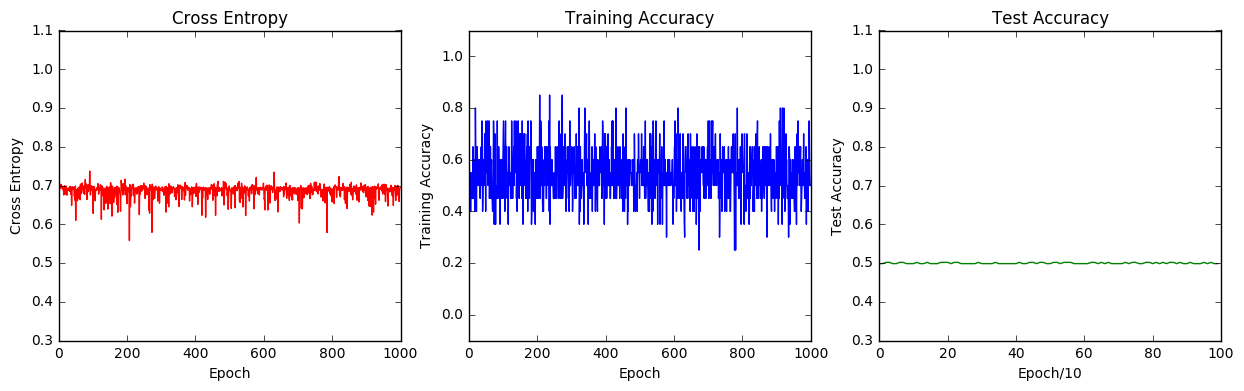

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

# load the data
err_list = np.load('{}epochs_err_list.npz'.format(num_epochs))['a']
train_acc = np.load('{}epochs_train_acc.npz'.format(num_epochs))['a']
test_acc = np.load('{}epochs_test_acc.npz'.format(num_epochs))['a']

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(np.arange(num_epochs), err_list, color='r')
plt.title('Cross Entropy')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.ylim([0.3, 1.1])


plt.subplot(1,3,2)
plt.plot(np.arange(num_epochs), train_acc, color='b')
plt.title('Training Accuracy')
plt.ylabel('Training Accuracy')
plt.xlabel('Epoch')
plt.ylim([-0.1, 1.1])

plt.subplot(1,3,3)
plt.plot(np.arange(num_epochs/10), test_acc, color='g')
plt.title('Test Accuracy')
plt.ylabel('Test Accuracy')
plt.xlabel('Epoch/10')
plt.ylim([0.3, 1.1])

print("minibatch size = %d" %minibatch_size)
print("number of epoches = %d" %num_epochs)
print("test accuracy final epoch = %f" %test_acc[-1])

In [ ]:
correct_prediction = tf.equal(tf.argmax(tf.sigmoid(y), 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(sess.run(accuracy, feed_dict={x: configs_test, y_: labels_test}))